# Distributed alternating direction method of multipliers (ADMM)

In [1]:
import os
import json
import math
import copy
import sys
import bokeh
from oedisi.types.data_types import MeasurementArray, AdmittanceMatrix, Topology
import pyarrow.feather as feather
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from pydantic import BaseModel
from plotly.subplots import make_subplots
import glob
from oedisi.componentframework.system_configuration import (
    WiringDiagram,
    Component,
    Link,
)
from lindistflow_federate.adapter import (
    generate_graph,
    area_disconnects,
    disconnect_areas,
    reconnect_area_switches,
    get_area_source,
)
import networkx as nx

from oedisi.componentframework import wiring_diagram_utils

ROOT = os.getcwd()
OUTPUTS = f"{ROOT}/outputs"
BUILDS = f"{ROOT}/builds"
SCENARIOS = f"{ROOT}/scenarios"

## Select a scenario
Set the SCENARIOS index value from the available scenarios

In [19]:
dir = []
def list_files_scandir(path="."):
    with os.scandir(path) as entries:
        for entry in entries:
            if entry.is_file():
                if "system.json" in entry.path:
                    path, _ = entry.path.split("system.json", 1)
                    dir.append(path)
            elif entry.is_dir():
                list_files_scandir(entry.path)


# Specify the directory path you want to start from
directory_path = f"{SCENARIOS}/admm"
list_files_scandir(directory_path)
for i, d in enumerate(dir):
    print(i, d)

0 /home/tylor/dev/oedisi_dopf/scenarios/admm/ieee123/
1 /home/tylor/dev/oedisi_dopf/scenarios/admm/SFO/P1U/low/
2 /home/tylor/dev/oedisi_dopf/scenarios/admm/SFO/P1U/high/
3 /home/tylor/dev/oedisi_dopf/scenarios/admm/SFO/P1U/extreme/
4 /home/tylor/dev/oedisi_dopf/scenarios/admm/SFO/P1U/medium/
5 /home/tylor/dev/oedisi_dopf/scenarios/admm/SFO/P6U/low/


## Build the selected scenario
The build will create a new build_<scenario> folder and copy over the federate files as specified. Assume successful build if no errors are presented.

In [20]:
index = 0
path = dir[index]
_, scenario = path.split(SCENARIOS, 1)
build = f"{BUILDS}{scenario}"
output = f"{OUTPUTS}{scenario}"
os.system(
    f"oedisi build --system {path}system.json --component-dict {path}components.json --target-directory {build}"
)

Loading the components defined in /home/tylor/dev/oedisi_dopf/scenarios/admm/ieee123/components.json
Loading system json /home/tylor/dev/oedisi_dopf/scenarios/admm/ieee123/system.json
Building system in /home/tylor/dev/oedisi_dopf/builds/admm/ieee123/


0

## Model Topology
split model into areas using discconnection switches

In [21]:
topology_file = f"{output}/topology.json"
with open(topology_file) as f:
    topology = Topology.parse_obj(json.load(f))

In [22]:
import lindistflow_federate.adapter as ada
import copy

def get_system(path: str) -> WiringDiagram:
    with open(path) as f:
        system: WiringDiagram = WiringDiagram.parse_obj(json.load(f))
    return system

slack_bus, _ = topology.slack_bus[0].split(".", 1)

G = ada.generate_graph(topology.incidences, slack_bus)
print("Total: ", G)
graph = copy.deepcopy(G)
graph2 = copy.deepcopy(G)
boundaries = ada.area_disconnects(graph)
areas = ada.disconnect_areas(graph2, boundaries)
areas = ada.reconnect_area_switches(areas, boundaries)

for area in areas:
    print(area)
    src = []
    for u, v, a in boundaries:
        if area.has_edge(u, v):
            print("\t", a["id"])
            src.append((u, v, a))
    su, sv, sa = ada.get_area_source(G, slack_bus, src)
    print("\tsource: ", sa["id"])

Total:  Graph with 130 nodes and 129 edges
Graph with 42 nodes and 41 edges
	 sw2
	 sw3
	source:  sw2
Graph with 20 nodes and 19 edges
	 sw3
	source:  sw3
Graph with 20 nodes and 19 edges
	 sw2
	 sw4
	source:  sw2
Graph with 39 nodes and 38 edges
	 sw4
	 sw5
	source:  sw4
Graph with 17 nodes and 16 edges
	 sw5
	source:  sw5


In [24]:
topology = Topology.parse_file(f"{output}/topology.json")
base_voltage_df = pd.DataFrame(
    {
        "id": topology.base_voltage_magnitudes.ids,
        "value": topology.base_voltage_magnitudes.values,
    }
)
base_voltage_df.set_index("id", inplace=True)
base_voltages = base_voltage_df["value"]

In [25]:
# read data
v_real = feather.read_feather(f"{output}/voltage_real.feather")
v_imag = feather.read_feather(f"{output}/voltage_imag.feather")

# converter to complex
true_voltages = v_real.drop("time", axis=1).abs() + 1j * v_imag.drop("time", axis=1)
true_voltages["time"] = pd.to_datetime(v_real["time"], format="%Y-%m-%d %H:%M:%S")
true_voltages.set_index("time", inplace=True)

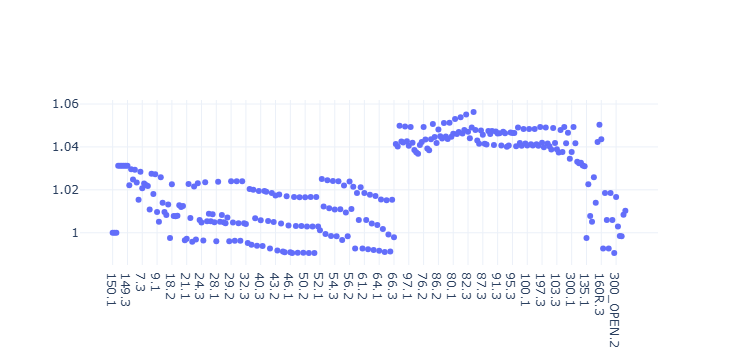

In [27]:
ts = dt.datetime(2018, 5, 1, 15)
true = true_voltages.loc[ts].abs() / base_voltages

fig = make_subplots(rows=1, cols=1)
fig.add_trace(
    go.Scatter(name="feeder", x=true.index, y=true.values, mode="markers"), row=1, col=1
)
fig.update_layout(template="plotly_white")
fig.show()

In [29]:
# read data
p_real = feather.read_feather(f"{output}/power_real.feather")
p_imag = feather.read_feather(f"{output}/power_imag.feather")

# filter missing nodes
common_columns = set(p_real.columns).intersection(p_imag.columns)
p_real = p_real.filter(common_columns)
p_imag = p_imag.filter(common_columns)

# convert to complex
true_powers = p_real.drop("time", axis=1) + 1j * p_imag.drop("time", axis=1)
true_powers["time"] = pd.to_datetime(p_real["time"], format="%Y-%m-%d %H:%M:%S")
true_powers.set_index("time", inplace=True)

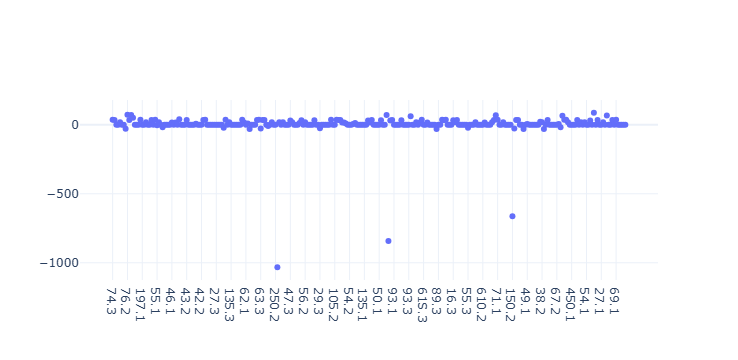

In [30]:
true = true_powers.loc[ts]

fig = make_subplots(rows=1, cols=1)
fig.add_trace(
    go.Scatter(name="feeder", x=true.index, y=true.values.real, mode="markers"),
    row=1,
    col=1,
)
fig.update_layout(template="plotly_white")
fig.show()

                     solve_time  num_iters  optimality_gap  feasibility_gap  \
time                                                                          
2018-05-01 15:00:00    0.012052        9.0             0.0              0.0   
2018-05-01 16:00:00    0.014410        9.0             0.0              0.0   
2018-05-01 17:00:00    0.014803       10.0             0.0              0.0   
2018-05-01 18:00:00    0.013683       10.0             0.0              0.0   
2018-05-01 19:00:00    0.013842       10.0             0.0              0.0   

                              sdn       vup  
time                                         
2018-05-01 15:00:00  4.228983e-10  0.041429  
2018-05-01 16:00:00  1.837009e-09  0.047392  
2018-05-01 17:00:00  5.960290e-11  0.054651  
2018-05-01 18:00:00  5.699105e-11  0.057431  
2018-05-01 19:00:00  7.850777e-11  0.057077  


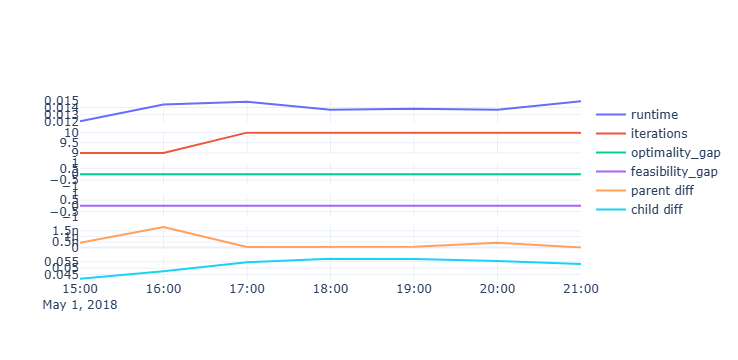

                     solve_time  num_iters  optimality_gap  feasibility_gap  \
time                                                                          
2018-05-01 15:00:00    0.006357        8.0             0.0              0.0   
2018-05-01 16:00:00    0.006250        7.0             0.0              0.0   
2018-05-01 17:00:00    0.006182        7.0             0.0              0.0   
2018-05-01 18:00:00    0.006316        7.0             0.0              0.0   
2018-05-01 19:00:00    0.006022        7.0             0.0              0.0   

                     sdn       vup  
time                                
2018-05-01 15:00:00  0.0  0.029336  
2018-05-01 16:00:00  0.0  0.033727  
2018-05-01 17:00:00  0.0  0.038026  
2018-05-01 18:00:00  0.0  0.039779  
2018-05-01 19:00:00  0.0  0.039763  


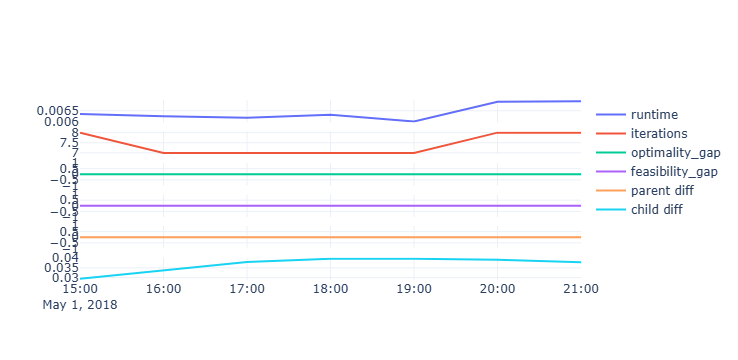

                     solve_time  num_iters  optimality_gap  feasibility_gap  \
time                                                                          
2018-05-01 15:00:00    0.006693        8.0             0.0              0.0   
2018-05-01 16:00:00    0.006868        8.0             0.0              0.0   
2018-05-01 17:00:00    0.006804        8.0             0.0              0.0   
2018-05-01 18:00:00    0.007184        8.0             0.0              0.0   
2018-05-01 19:00:00    0.009885        8.0             0.0              0.0   

                              sdn       vup  
time                                         
2018-05-01 15:00:00  7.547185e-09  0.017983  
2018-05-01 16:00:00  3.012645e-09  0.021583  
2018-05-01 17:00:00  3.438462e-09  0.023190  
2018-05-01 18:00:00  4.363571e-09  0.023828  
2018-05-01 19:00:00  3.571501e-09  0.024045  


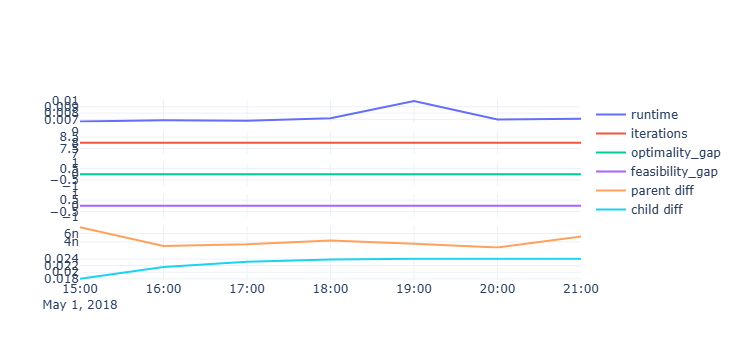

                     solve_time  num_iters  optimality_gap  feasibility_gap  \
time                                                                          
2018-05-01 15:00:00    0.008937        6.0             0.0              0.0   
2018-05-01 16:00:00    0.009066        6.0             0.0              0.0   
2018-05-01 17:00:00    0.009165        6.0             0.0              0.0   
2018-05-01 18:00:00    0.009121        6.0             0.0              0.0   
2018-05-01 19:00:00    0.008674        6.0             0.0              0.0   

                          sdn       vup  
time                                     
2018-05-01 15:00:00  0.120761  0.100998  
2018-05-01 16:00:00  0.245643  0.106528  
2018-05-01 17:00:00  0.388632  0.109371  
2018-05-01 18:00:00  0.348268  0.110569  
2018-05-01 19:00:00  0.386281  0.111005  


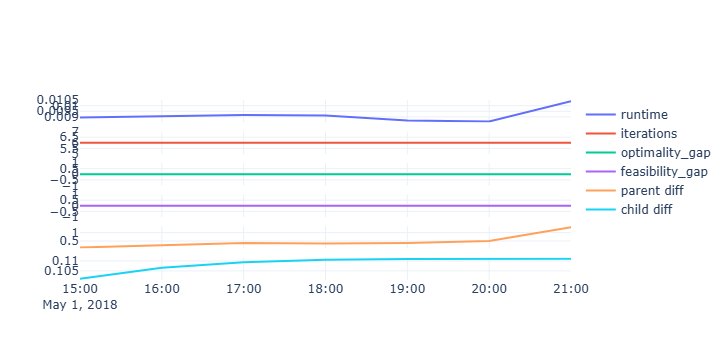

                     solve_time  num_iters  optimality_gap  feasibility_gap  \
time                                                                          
2018-05-01 15:00:00    0.006239        9.0             0.0              0.0   
2018-05-01 16:00:00    0.006268        9.0             0.0              0.0   
2018-05-01 17:00:00    0.006207        9.0             0.0              0.0   
2018-05-01 18:00:00    0.009272        9.0             0.0              0.0   
2018-05-01 19:00:00    0.008245        9.0             0.0              0.0   

                     sdn       vup  
time                                
2018-05-01 15:00:00  0.0  0.014161  
2018-05-01 16:00:00  0.0  0.024406  
2018-05-01 17:00:00  0.0  0.030861  
2018-05-01 18:00:00  0.0  0.033256  
2018-05-01 19:00:00  0.0  0.033389  


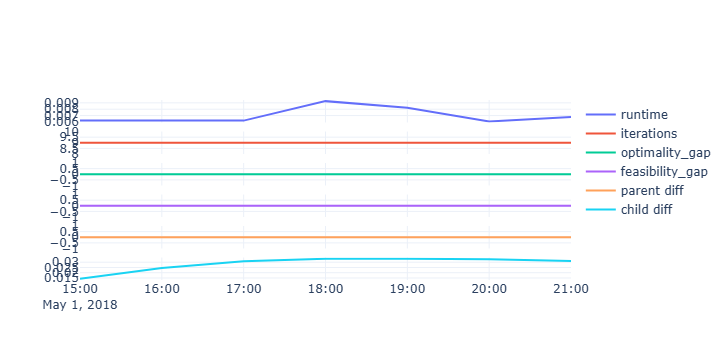

In [28]:
for idx in range(5):
    # read data
    stats = feather.read_feather(f"{output}/solver_stats_admm_{idx}.feather")
    stats["time"] = pd.to_datetime(stats["time"], format="%Y-%m-%d %H:%M:%S")
    stats.set_index("time", inplace=True)
    
    print(stats.head())
    fig = make_subplots(rows=6, cols=1,shared_xaxes=True)
    fig.add_trace(go.Scatter(name="runtime", x=stats.index, y=stats.solve_time, mode="lines"), row=1, col=1)
    fig.add_trace(go.Scatter(name="iterations", x=stats.index, y=stats.num_iters, mode="lines"), row=2, col=1)
    fig.add_trace(go.Scatter(name="optimality_gap", x=stats.index, y=stats.optimality_gap, mode="lines"), row=3, col=1)
    fig.add_trace(go.Scatter(name="feasibility_gap", x=stats.index, y=stats.feasibility_gap, mode="lines"), row=4, col=1)
    fig.add_trace(go.Scatter(name="parent diff", x=stats.index, y=stats.sdn, mode="lines"), row=5, col=1)
    fig.add_trace(go.Scatter(name="child diff", x=stats.index, y=stats.vup, mode="lines"), row=6, col=1)
    fig.update_layout(template="plotly_white")
    fig.show()